In [ ]:
import numpy as np
from os.path import exists
from os import makedirs
import imageio.core.util
from facenet_pytorch import MTCNN
from PIL import Image
import pandas as pd
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.core import Dropout, Dense
from keras.models import Model
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import CSVLogger
from sklearn.model_selection import train_test_split
from keras.applications.xception import Xception
from matplotlib import pyplot as plt
from keras import backend


In [ ]:

def cnn_pretrain_model( img_size):
   
    input_size = (img_size, img_size, 3)
    baseModel = Xception(
            weights="imagenet",
            include_top=False,
            input_shape=(img_size, img_size, 3)
    headModel = baseModel.output
    headModel = GlobalAveragePooling2D()(headModel)
    headModel = Dense(512, activation="relu", kernel_initializer="he_uniform")(
        headModel
    )
    headModel = Dropout(0.4)(headModel)

    headModel = Dropout(0.5)(headModel)
    predictions = Dense(
        2,
        activation="softmax",
        kernel_initializer="he_uniform")(
        headModel
    )
    model = Model(inputs=baseModel.input, outputs=predictions)

    for layer in baseModel.layers:
        layer.trainable = True

    optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    # model.compile(loss="categorical_crossentropy",optimizer=adam,metrics=["accuracy"])
    model.compile(loss="categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])
    return model


Dataset Loaded...
(11908, 160, 160, 3) (1324, 160, 160, 3) (11908, 2) (1324, 2)
Total params: 21,911,594
Trainable params: 21,857,066
Non-trainable params: 54,528
Training is going to start in 3... 2... 1... 


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/21
372/372 [==============================] - 164s 317ms/step - loss: 0.6483 - accuracy: 0.6909 - val_loss: 233.0221 - val_accuracy: 0.7134

Epoch 00001: val_loss improved from inf to 233.02211, saving model to trained_wts/xception_best.hdf5
Epoch 2/21
372/372 [==============================] - 120s 322ms/step - loss: 0.6140 - accuracy: 0.7043 - val_loss: 0.6052 - val_accuracy: 0.7157

Epoch 00002: val_loss improved from 233.02211 to 0.60525, saving model to trained_wts/xception_best.hdf5
Epoch 3/21
372/372 [==============================] - 122s 327ms/step - loss: 0.6097 - accuracy: 0.7062 - val_loss: 3.5705 - val_accuracy: 0.7134

Epoch 00003: val_loss did not improve from 0.60525
Epoch 4/21
372/372 [==============================] - 122s 328ms/step - loss: 0.6190 - accuracy: 0.6940 - val_loss: 0.6003 - val_accuracy: 0.7134

Epoch 00004: val_loss improved from 0.60525 to 0.60025, saving model to trained_wts/xception_best.hdf5
Epoch 5/21
372/372 [==============================

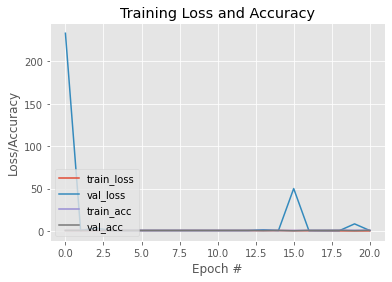

In [ ]:

def main():
 
    epochs = 21
    image_size = 160
    batch_size = 32
    weights_save_name = "Weights_trained" 

    train_data = np.load("/content/drive/MyDrive/dataset/npy files/train_data.npy")
    train_label = np.load("/content/drive/MyDrive/dataset/npy files/train_label.npy")


    trainX, valX, trainY, valY = train_test_split(train_data, train_label, test_size=0.25, shuffle=False)

    # Train nad validation image data generator
    # https://keras.io/api/preprocessing/image/
    trainAug = ImageDataGenerator(
        rescale=1.0 / 255.0,
        samplewise_center=False,
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=None,
        shear_range=0.15,
        zoom_range=0.0,
        channel_shift_range=0.0,
        fill_mode='nearest', 
        cval=0.0,
        horizontal_flip=True,
        validation_split=0.0, 
       
    )

    valAug = ImageDataGenerator(rescale=1.0 / 255.0)

    model = cnn_pretrain_model(model_name, img_size=image_size)

    trainable_count = int(np.sum([K.count_params(p) for p in model.trainable_weights]))
    non_trainable_count = int(np.sum([K.count_params(p) for p in model.non_trainable_weights]))
    
    print(trainX.shape, valX.shape)
    print(trainY.shape, valY.shape)

  
    makedirs("./trained_wts")
    model_checkpoint = ModelCheckpoint(
        "trained_wts/" + weights_save_name + ".hdf5",
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
    )
    makedirs("./training_logs")
    stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0)
    csv_logger = CSVLogger("training_logs/xception.log",separator=",",append=True,)

    print("Fiting the model ")

    History = model.fit_generator(
        trainAug.flow(trainX, trainY, batch_size=batch_size),
        steps_per_epoch=len(trainX) // batch_size,
        validation_data=valAug.flow(valX, valY),
        validation_steps=len(valX) // batch_size,
        epochs= epochs,
        callbacks=[model_checkpoint, stopping, csv_logger],
    )
    plt.style.use("seaborn")
    plt.style.use("ggplot")
    plt.figure()
    N = 21
    epos = range(0,21)
    makedirs("./plots")
    plt.plot( epos, History.history["loss"], label="train_loss")
    plt.plot( epos,History.history["val_loss"], label="val_loss")
    plt.plot(epos, History.history["accuracy"], label="train_acc")
    plt.plot(epos,History.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Loss and Accuracy")
    plt.savefig("plots/training_plot.png")

if __name__ == "__main__":
    main()


In [ ]:
from google.colab import files
files.download("/content/file.zip")

## Test

In [ ]:
videos =[]
labels =[]
with open("/content/List_of_testing_videos.txt", "r") as f:
  for line in f:
    videos_list += [line.split(' ')[1]]
    labels_list  += line.split(' ')[0]
    # print(line.split(' ')[1],line.split(' ')[0])
     

In [ ]:
from facenet_pytorch import MTCNN
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)

mtcnn = MTCNN(
        margin=40,
        select_largest=False,
        post_process=False,
        device="cuda:0"
    )


def main():
   
    load_weights_name = "Weights_trained"
    img_size = 160
    test_data = labels
    videos = videos_list
    true_labels = labels_list


    model = cnn_pretrain_model( img_size=image_size)
    model.load_weights("trained_wts/" + load_weights_name + ".hdf5")

    y_predictions = []
    y_probabilities = []
    videos_done = 0

    for video in videos:
        cap = cv2.VideoCapture(video)
        batches = []

        # Number of frames taken into consideration for each video
        while (cap.isOpened() and len(batches) < 40):
            ret, frame = cap.read()
            if ret is True:
              frame = cv2.resize(frame, (args.img_size, args.img_size))
              frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
              frame = Image.fromarray(frame)
              face = mtcnn(frame)

              try:
                  face = face.permute(1, 2, 0).int().numpy()
                  batches.append(face)
              except AttributeError:
                  print("Image Skipping")

        batches = np.asarray(batches).astype("float32")
        batches /= 255
 
        y_probabilities += [np.mean(model.predict(batches), axis=0)]
        y_predictions += [np.mean(model.predict(batches).argmax(0)]
        cap.release()

        if videos_done % 100 == 0:
            print("Number of videos done:", videos_done)
        videos_done += 1
# https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case
    print("Accuracy Score:", accuracy_score(true_labels, y_predictions))
    print("Precision Score:", precision_score(true_labels, y_predictions))
    print("Recall Score:", recall_score(true_labels, y_predictions))
    print("F1 Score:", f1_score(true_labels, y_predictions))
   
    np.save("yPredictions.npy", y_predictions)
    np.save("yProbabilities.npy", y_probabilities)


if __name__ == "__main__":
    main()


#Lstm 

In [ ]:
#  not in the working condition ---
from keras import backend 
def lstm_model(train_data):

    main_input = Input(
        shape=(train_data.shape[1],
               train_data.shape[2]),
        name="main_input"
    )
  
    headModel = LSTM(32)(main_input)
    headModel = TemporalMaxPooling()(headModel)
    headModel = TimeDistributed(Dense(512))(headModel)
  
    headModel = LSTM(256)(headModel)
    predictions = Dense(
        2,
        activation="softmax",
        kernel_initializer="he_uniform"
    )(headModel)
    model = Model(inputs=main_input, outputs=predictions)


    model.compile(
        loss="categorical_crossentropy",
        optimizer=adam,
        metrics=["accuracy"]
    )

    return model

model = lstm_model(train_data)
History = model.fit(
        trainX,
        trainY,
        validation_data=(valX, valY),
        batch_size=args.batch_size,
        epochs=args.epochs,
        shuffle=True,
        callbacks=[model_checkpoint, stopping],
    )

In [ ]:
# Temporal layer 
from keras import backend 
def call(self, inp, mask=None):
  
        if backend._BACKEND == "tensorflow":
            mask = backend.expand_dims(mask, axis=-1)
            masked_data = backend.tf.where(backend.equal(mask, K.zeros_like(mask)), K.ones_like(x) * -np.inf, inp) 
            return K.max(masked_data, axis=1)
        else: 
            mask = mask.dimshuffle(0, 1, "x")
            masked_data = K.switch(K.eq(mask, 0), -np.inf, inp)
            return masked_data.max(axis=1)

